### Singeltask 

In [32]:
import os 
import pandas as pd

ITERATIONS = 5
columns=["dataset", "accuracy", "precision", "recall", "duration","epoch"] #"best_val_acc", "epoch"]
stl_results_fcn = pd.DataFrame(columns=columns)
stl_results_res = pd.DataFrame(columns=columns)


for idx, dataset in enumerate(['GunPoint','Beef','ECG200']): #'ECG5000']):

    bac = 0; acc=0; precision=0; recall=0; duration=0

    for itr in range(ITERATIONS): 
        fcn_best_model = pd.read_csv(f'./results/ucr/{dataset}/experiment_1/fcn/fcn_{itr}/original/df_best_model.csv')
        fcn_metrics = pd.read_csv(f'./results/ucr/{dataset}/experiment_1/fcn/fcn_{itr}/original/task1_df_metrics.csv')
        fcn_hist = pd.read_csv(f'./results/ucr/{dataset}/experiment_1/fcn/fcn_{itr}/original/history.csv')

        res_best_model = pd.read_csv(f'./results/ucr/{dataset}/experiment_1/resnet/resnet_{itr}/original/df_best_model.csv')
        res_metrics = pd.read_csv(f'./results/ucr/{dataset}/experiment_1/resnet/resnet_{itr}/original/task1_df_metrics.csv')
        res_hist = pd.read_csv(f'./results/ucr/{dataset}/experiment_1/resnet/resnet_{itr}/original/history.csv')

        fcn_vals = [
                    max(fcn_metrics["accuracy"].values), max(fcn_metrics["precision"]),
                    max(fcn_metrics["recall"].values), max(fcn_metrics["duration"]), 
                    list(fcn_hist["val_accuracy"]).index(max(fcn_hist["val_accuracy"]))
                    #max(fcn_hist["val_accuracy"])
                    ] 
        res_vals = [ 
                    res_metrics["accuracy"].values[0], res_metrics["precision"].values[0],
                    res_metrics["recall"].values[0], res_metrics["duration"].values[0],
                    list(res_hist["val_accuracy"]).index(max(res_hist["val_accuracy"]))
                    #max(res_hist["val_accuracy"])
                    ]
        #Read STL results for FCN classifier
        if itr == 0:
            stl_results_fcn.loc[idx] = [dataset] + fcn_vals
            stl_results_res.loc[idx] = [dataset] + res_vals
        else:
            stl_results_fcn.loc[idx, columns[1:]] += fcn_vals
            stl_results_res.loc[idx, columns[1:]] += res_vals

    

    stl_results_fcn.loc[idx, columns[1:]] /= ITERATIONS
    stl_results_res.loc[idx, columns[1:]] /= ITERATIONS

In [11]:
stl_results_fcn.to_csv("./results_csv/experiment1a/test_results_classification_fcn.csv")
stl_results_fcn.to_latex("./results_csv/experiment1a/test_results_classification_fcn.tex")
stl_results_res.to_csv("./results_csv/experiment1a/test_results_classification_resnet.csv")
stl_results_res.to_latex("./results_csv/experiment1a/test_results_classification_resnet.tex")
display(stl_results_fcn)
display(stl_results_res)

C:\Users\boent\AppData\Local\Temp\ipykernel_32648\604288730.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  stl_results_fcn.to_latex("./results_csv/experiment1a/test_results_classification_fcn.tex")
C:\Users\boent\AppData\Local\Temp\ipykernel_32648\604288730.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  stl_results_res.to_latex("./results_csv/experiment1a/test_results_classification_resnet.tex")


,dataset,accuracy,precision,recall,duration,epoch
0,GunPoint,0.992000,0.992405,0.991892,70.777516,134.8
1,Beef,0.546667,0.641308,0.546667,55.480688,399.8
2,ECG200,0.890000,0.883365,0.876389,64.748806,105.4


,dataset,accuracy,precision,recall,duration,epoch
0,GunPoint,0.989333,0.989744,0.989189,294.517580,63.0
1,Beef,0.760000,0.803612,0.760000,231.106733,310.2
2,ECG200,0.874000,0.871268,0.851736,233.101935,199.0


### Get Classstats of Attribution methods (similar to DataExploration)

- Plotting by class
- Get MAE for all instances and classwise 
- Get Pearson for all instances and classwise 

In [33]:
from utils.utils import read_dataset
import numpy as np
#MAE over all dataset instances and classwise: 
root_dir = 'G:/Meine Ablage/master thesis/code/xai-tsc'
archive_name = 'ucr'

def calculate_inbetween_distance(dataset_name):
    #load dataset
    datasets_dict = read_dataset(root_dir, archive_name, dataset_name, 'original', 1)
    x_train, y_train, x_test, y_test = datasets_dict[dataset_name]
    ylen = len(x_train[0])
    datasets_dict = read_dataset(root_dir, archive_name, dataset_name, 'fcn_ig_norm', ylen)
    _, y_train_2, _, y_test_2 = datasets_dict[dataset_name]

    output = []
    for x_vals,y_vals in [[y_train_2,y_train],[y_test_2,y_test]]:
        mean_inbetween_distance = 0 
        mean_inbetween_distance_classwise = dict()
        for x,y in zip(x_vals,y_vals):
            if int(y) not in mean_inbetween_distance_classwise.keys(): mean_inbetween_distance_classwise[int(y)] = []
            for x_n,y_n in zip(x_vals,y_vals):
                if np.array_equal(x,x_n): continue
                mae = mean_absolute_error(x,x_n)
                if y == y_n: mean_inbetween_distance_classwise[int(y)].append(mae)
                mean_inbetween_distance += mae
        classwise_dist = []
        for k in mean_inbetween_distance_classwise.keys():
            mean_inbetween_distance_classwise[k] = sum(mean_inbetween_distance_classwise[k]) / len(mean_inbetween_distance_classwise[k])
            classwise_dist.append(mean_inbetween_distance_classwise[k]) 
        mean_inbetween_distance = mean_inbetween_distance / len(x_vals)
        output.append([mean_inbetween_distance, *classwise_dist])
    return pd.DataFrame(output, columns = ["MAE diff", *[f'class {i}'for i in range(len(np.unique(y_train)))]])



#Pearson over all dataset instances and classwise: 
def calculate_inbetween_corr_attribution_training_data(dataset_name):

    #load dataset
    datasets_dict = read_dataset(root_dir, archive_name, dataset_name, 'original', 1)
    x_train, y_train, x_test, y_test = datasets_dict[dataset_name]
    ylen = len(x_train[0])
    datasets_dict = read_dataset(root_dir, archive_name, dataset_name, 'fcn_ig_norm', ylen)
    _, y_train_2, _, y_test_2 = datasets_dict[dataset_name]

    output = []
    count = 0
    for x_vals,y_vals in [[y_train_2,y_train],[y_test_2,y_test]]:
        mean_inbetween_corr = 0 
        mean_inbetween_corr_classwise = dict()
        for x,y in zip(x_vals,y_vals):
            if int(y) not in mean_inbetween_corr_classwise.keys(): mean_inbetween_corr_classwise[int(y)] = []
            for x_n,y_n in zip(x_vals,y_vals):
                if np.array_equal(x,x_n): continue
                corr = np.corrcoef(x,x_n)[0,1]
                if y == y_n: mean_inbetween_corr_classwise[int(y)].append(corr)
                mean_inbetween_corr += corr
                count += 1
        classwise_dist = []
        for k in mean_inbetween_corr_classwise.keys():
            mean_inbetween_corr_classwise[k] = sum(mean_inbetween_corr_classwise[k]) / len(mean_inbetween_corr_classwise[k])
            classwise_dist.append(mean_inbetween_corr_classwise[k]) 
        print(mean_inbetween_corr,len(x_vals))
        mean_inbetween_corr = mean_inbetween_corr / count
        output.append([mean_inbetween_corr, *classwise_dist])
    return pd.DataFrame(output, columns = ["Corr mean", *[f'class {i}'for i in range(len(np.unique(y_train)))]])


#calculate_inbetween_distance("GunPoint")
#display("GunPoint", calculate_inbetween_corr_attribution_training_data("GunPoint"))
#display("ECG200", calculate_inbetween_corr_attribution_training_data("ECG200"))
#display("Beef", calculate_inbetween_corr_attribution_training_data("Beef"))

In [55]:
pd.concat([calculate_inbetween_corr_attribution_training_data("GunPoint"),calculate_inbetween_corr_attribution_training_data("ECG200"),calculate_inbetween_corr_attribution_training_data("Beef")],axis=1).round(2).to_latex("./results_csv/Experiment1a/corr_mean_classinter.tex")

75.09338070167998 50
197.8358348209597 150
1216.5573310822285 100
1000.6247737837285 100
31.929657372482644 30
110.14902383402497 30


C:\Users\boent\AppData\Local\Temp\ipykernel_11696\1716055858.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  pd.concat([calculate_inbetween_corr_attribution_training_data("GunPoint"),calculate_inbetween_corr_attribution_training_data("ECG200"),calculate_inbetween_corr_attribution_training_data("Beef")],axis=1).round(2).to_latex("./results_csv/Experiment1a/corr_mean_classinter.tex")


### Test Similarity of Attribution methods

- raw unscaled attribution vectors
- pearson 

In [35]:
import numpy as np
from utils.utils import read_dataset
import pandas as pd
import os
import matplotlib.pyplot as plt


archive = 'ucr'
dataset_name = 'GunPoint'
data_p = 'G:/Meine Ablage/master thesis/code/xai-tsc'

train_val = []
test_val  = []

for idx, dataset in enumerate(os.listdir('./archives/ucr')):
    ylen = 1
    data = read_dataset(data_p, archive, dataset, 'original', ylen)[dataset]
    ylen = len(data[0][0])
    try:
        _,cy,_,cy1 = read_dataset(data_p, archive, dataset, 'fcn_cam_norm', ylen)[dataset]
        _,igy,_,igy1 = read_dataset(data_p, archive, dataset, 'fcn_ig_norm', ylen)[dataset]
        train_val.append([dataset,np.mean(np.corrcoef(cy, igy, rowvar=True)), np.mean(np.square(cy- igy))])
        test_val.append([dataset,np.mean(np.corrcoef(cy1,igy1,rowvar=True)),  np.mean(np.square(cy1- igy1))])
    except Exception as e: 
        #print(dataset,"error", e)
        pass

    
pd.DataFrame(train_val,columns=["dataset", "correlation","mse"])
pd.DataFrame(test_val,columns=["dataset", "correlation", "mse"])


,dataset,correlation,mse
0,GunPoint,0.043283,0.016084
1,Beef,0.115806,0.004116
2,ECG200,0.125237,0.019328
3,ECG5000,0.093271,0.014634


### Check the similarity of attributions after differnet trainings


In [36]:
from utils.explanations import calculate_ig_attributions, norm
import matplotlib.pyplot as plt
train_att_array = []
test_att_array = []
ITERATIONS = 5
model_type ="resnet"
form = "norm"
model = "resnet"
expl_type  = "ig_norm"

correlations = dict()
train_att_array = []


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
for idx, dataset in enumerate(['GunPoint','ECG200','Beef']):
    #read baseline attributions 
    #len of datasets GunPoint, ECG200, Beef
    timeseries_len = [150,96,470]
    datasets_len_train = [50,100,30]
    datasets_len_test = [150,100,30]
    data_stl  = read_dataset(data_p, archive, dataset, f'{model_type}_{expl_type}',timeseries_len[idx])[dataset]
    correlations[dataset] = {
        "train" : [],
        "test" :  []
    }
    axes[idx].set_title(f"{dataset}")
    axes[idx].plot(np.arange(len(data_stl[3][0])),data_stl[3][0])
    #Calculate attributions 
    for itr in range(ITERATIONS):
        #calculate ig attributions
        attributions = calculate_ig_attributions(root_dir, archive, f"{model}_{itr}", dataset, f"original", task=0, experiment=1,scale="normalized")
        # get values 
        train_raw_att_vals = np.array([att[2] for att in attributions[0]]) 
        test_raw_att_vals = np.array([att[2] for att in attributions[1]]) 
        train_corr = 0; test_corr = 0
        #train data
        for ts1, ts2 in zip(data_stl[1],train_raw_att_vals):
            train_corr += np.corrcoef(ts1,norm(ts2))[0,1]
        for ts1, ts2 in zip(data_stl[3],test_raw_att_vals):
            test_corr += np.corrcoef(ts1,norm(ts2))[0,1]

        train_corr /= datasets_len_train[idx]
        test_corr /= datasets_len_test[idx]

        #plot first time series for visualization
        axes[idx].plot(np.arange(len(test_raw_att_vals[0])),norm(test_raw_att_vals[0]), label=f"TS {0} / PCC {np.round(np.corrcoef(data_stl[3][0],norm(test_raw_att_vals[0]))[0,1],3)}")
        axes[idx].legend(loc="lower right")

        correlations[dataset]["train"].append(train_corr)
        correlations[dataset]["test"].append(test_corr)




G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/GunPoint//experiment_1/resnet/resnet_0/original/best_model.hdf5
5/5 [==============================] - 0s 20ms/step
G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/GunPoint//experiment_1/resnet/resnet_1/original/best_model.hdf5
5/5 [==============================] - 0s 21ms/step
G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/GunPoint//experiment_1/resnet/resnet_2/original/best_model.hdf5
5/5 [==============================] - 0s 33ms/step
G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/GunPoint//experiment_1/resnet/resnet_3/original/best_model.hdf5
5/5 [==============================] - 0s 28ms/step
G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/GunPoint//experiment_1/resnet/resnet_4/original/best_model.hdf5
5/5 [==============================] - 0s 29ms/step
G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/ECG200//experiment_1/resnet/resnet_0/original/best_model.hdf5
4/4 [=======================

In [45]:
display(pd.DataFrame(correlations["GunPoint"]))
display(pd.DataFrame(correlations["ECG200"]))
display(pd.DataFrame(correlations["Beef"]))
#intersimilarity fcn
#pd.concat([pd.DataFrame(correlations["GunPoint"]), pd.DataFrame(correlations["ECG200"]),pd.DataFrame(correlations["Beef"])],axis=1).to_latex("./results_csv/Experiment1a/intersimilarity.tex")
# intersimilarity resnet
pd.concat([pd.DataFrame(correlations["GunPoint"]), pd.DataFrame(correlations["ECG200"]),pd.DataFrame(correlations["Beef"])],axis=1).to_latex("./results_csv/Experiment1a/intersimilarity_resnet.tex")

,train,test
0,0.858113,0.830577
1,1.000000,1.000000
2,0.569260,0.542645
3,0.797936,0.758310
4,0.754376,0.717475


,train,test
0,0.887175,0.854940
1,1.000000,1.000000
2,0.886423,0.847648
3,0.883240,0.845287
4,0.887842,0.852217


,train,test
0,0.719655,0.437852
1,1.000000,1.000000
2,0.304517,0.099338
3,0.792066,0.557593
4,0.055896,0.149743


C:\Users\boent\AppData\Local\Temp\ipykernel_11696\3523802684.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  pd.concat([pd.DataFrame(correlations["GunPoint"]), pd.DataFrame(correlations["ECG200"]),pd.DataFrame(correlations["Beef"])],axis=1).to_latex("./results_csv/Experiment1a/intersimilarity.tex")


In [26]:
train_att_array

[]

### Calcualte Custom Metrics for Attribution Prediction Task 


<text color="red">rework required</text>

In [22]:
import tensorflow_addons as tfa
from utils.explanations import integrated_gradients
from keras.utils import CustomObjectScope
import tensorflow.keras as keras
import tensorflow as tf
import os
from utils.explanations import minmax_norm
from utils.explanations import calculate_ig_attributions, calculate_cam_attributions
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils.utils import read_dataset
from sklearn.preprocessing import normalize
import numpy as np



# Load model to calculate custom metrics 
def load_model(root_dir, archive_name, dataset_name, classifier, data_source): 
    with CustomObjectScope({'InstanceNormalization':tfa.layers.InstanceNormalization()}):
        model_path = f'{root_dir}/results/{archive_name}/{dataset_name}/' \
                                                + f'{classifier.split("_")[0]}/{classifier}/{data_source}/' \
                                                + f'best_model.hdf5'
        model =keras.models.load_model(model_path ,compile=False)
        return model
    

def norm(values): 
    if not type(values) == np.ndarray:
        return normalize(values.numpy().reshape(1,-1))[0]
    else: 
        return normalize(values.reshape(1,-1))[0]
    
#define shared trunk
network = 'fcn' 
expl_type = 'ig_norm'
#store custom metrics for model
models_train  = dict()
models_test   = dict()
# Loop over data


columns = ["dataset","model", "pm1",  "mm1" ]
models_train =  pd.DataFrame(columns=columns)
models_test = pd.DataFrame(columns=columns)
ITERATIONS = 2

position = 0


for idx, dataset in enumerate(['ECG200']):#enumerate(os.listdir('./archives/ucr')):,'Coffee','Beef','ECG200'
    print(dataset)
    ylen = 1
    #Just for now:

    data = read_dataset(data_p, archive, dataset, 'original', ylen)[dataset]
    #assertion,each ts has same length
    ylen = len(data[0][0])

    for model in ['fcn_mt_conv']: #'fcn_mt_linear']: #['fcn_mt_ae','fcn_mt_conv', 'fcn_mt_linear']: 
        model_type = model.split('_')[0] 
        for itr in range(ITERATIONS): 
            data_stl  = read_dataset(data_p, archive, dataset, f'{model_type}_{expl_type}', ylen)[dataset]
            model_link  = f'./results/ucr/{dataset}/experiment_1/{model_type}/{model}_{itr}/{model_type}_{expl_type}/best_model.hdf5'
            loaded_model = keras.models.load_model(model_link ,compile=False)
            for t in [1,3]:
                tc = t 
                #Pearson and mse [p,m]
                pm1 = 0;  mm1 = 0 
                #predict values for all timeseries 
                pred = loaded_model.predict(data[t-1])
                #run loop
                for ts in range(len(data[t])):                
                    #structure of attributions 0 --> train 1 --> test set
                    pm1 += np.corrcoef(pred[1][ts].flatten(),data_stl[t][ts])[0,1]
                    mm1 += mean_squared_error(pred[1][ts].flatten(),data_stl[t][ts])
                #Init for model 
                l = len(data[t])
                if itr == 0:
                    if t == 1: 
                        models_train.loc[position] = [dataset, model, pm1/l, mm1/l]
                    else: 
                        models_test.loc[position]  =[dataset, model, pm1/l, mm1/l]
                else:
                    if t == 1: 
                        models_train.loc[position, columns[2:]] += [(pm1/l),(mm1/l)]
                    else:                                                      
                        models_test.loc[position, columns[2:]] += [(pm1/l), (mm1/l)]
        position += 1
    position += 1

    

c:\Users\boent\anaconda3\envs\xai-tsc\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


ECG200
4/4 [==============================] - 0s 5ms/step


##### FCN 

In [23]:
import pandas as pd
display(pd.DataFrame(models_train))
display(pd.DataFrame(models_test))


models_train["pm1"].mean()

,dataset,model,pm1,mm1
0,ECG200,fcn_mt_conv,1.8139,0.00381


,dataset,model,pm1,mm1
0,ECG200,fcn_mt_conv,1.089257,0.016824


1.8139000164750472

In [9]:
import pandas as pd
pd.read_csv("./results_csv/Experiment2/test_data_5runs.csv")["pm3"].min(), pd.read_csv("./results_csv/Experiment2/test_data_5runs.csv")["pm3"].max(),pd.read_csv("./results_csv/Experiment2/test_data_5runs.csv")["pm3"].mean()

(0.2323141394948575, 0.8405306691596884, 0.6002678690367294)

In [18]:
#pd.DataFrame(models_test).T.to_latex('./results_csv/experiment1c/test_results_fcn.tex')
#pd.DataFrame(models_test).T.to_csv('./results_csv/experiment1c/test_results_fcn.csv')

C:\Users\boent\AppData\Local\Temp\ipykernel_32648\2035812856.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  pd.DataFrame(models_test).T.to_latex('./results_csv/experiment1c/test_results_fcn.tex')


#### ResNet

In [23]:
import pandas as pd
models_train = pd.read_csv
display(pd.DataFrame(models_train).T)
display(pd.DataFrame(models_test).T)

,0
dataset,ECG200
model,fcn_mt_nn
pm1,0.999297
mm1,0.000013


,0
dataset,ECG200
model,fcn_mt_nn
pm1,0.483942
mm1,0.00817


In [6]:
#pd.DataFrame(models_test).T.to_latex('./results_csv/experiment1c/test_results_resnet.tex')
#pd.DataFrame(models_test).T.to_csv('./results_csv/experiment1c/test_results_resnet.csv')

C:\Users\boent\AppData\Local\Temp\ipykernel_32648\2700811303.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  pd.DataFrame(models_test).T.to_latex('./results_csv/experiment1c/test_results_resnet.tex')


In [46]:
def calculate_inbetween_corr(dataset_name, model, expl_type):
    model_type = model.split("_")[0]
    #load dataset
    ig_link  = f'./results/ucr/{dataset_name}/experiment_1/{model_type}/{model}_{itr}/{expl_type}/best_model.hdf5'
    print(ig_link)
    loaded_model = keras.models.load_model(ig_link ,compile=False)

    print(root_dir, archive_name, dataset_name, 'original', 1)
    datasets_dict = read_dataset(root_dir, archive_name, dataset_name, 'original', 1)
    x_train, y_train, x_test, y_test = datasets_dict[dataset_name]
    ylen = len(x_train[0])

    datasets_dict = read_dataset(root_dir, archive_name, dataset_name, expl_type, ylen)
    _, y_train_2, _, y_test_2 = datasets_dict[dataset_name]

    output = []
    for x_vals,y_vals_2, y_vals in [[x_train, y_train_2,y_train],[x_test,y_test_2,y_test]]:
        mean_inbetween_corr = 0 
        mean_inbetween_corr_classwise = dict()
        pred = loaded_model.predict(x_vals)[1]

        for pr,y2,y in zip(pred,y_vals_2, y_vals):
            if int(y) not in mean_inbetween_corr_classwise.keys(): mean_inbetween_corr_classwise[int(y)] = []
            corr = np.corrcoef(y2,pr.flatten())[0,1]
            mean_inbetween_corr_classwise[int(y)].append(corr)
            mean_inbetween_corr += corr
        classwise_dist = []
        for k in mean_inbetween_corr_classwise.keys():
            mean_inbetween_corr_classwise[k] = sum(mean_inbetween_corr_classwise[k]) / len(mean_inbetween_corr_classwise[k])
            classwise_dist.append(mean_inbetween_corr_classwise[k]) 
        mean_inbetween_corr = mean_inbetween_corr / len(x_vals)
        output.append([mean_inbetween_corr, *classwise_dist])
    return pd.DataFrame(output, columns = ["Corr Mean", *[f'class {i}'for i in range(len(np.unique(y_train)))]])


#calculate_inbetween_distance("GunPoint")
display(calculate_inbetween_corr("GunPoint", "fcn_mt_ae", "fcn_ig_norm"))
display(calculate_inbetween_corr_attribution_training_data("GunPoint"))

./results/ucr/GunPoint/experiment_1/fcn/fcn_mt_ae_4/fcn_ig_norm/best_model.hdf5
G:/Meine Ablage/master thesis/code/xai-tsc ucr GunPoint original 1
5/5 [==============================] - 0s 23ms/step


,Corr Mean,class 0,class 1
0,0.990986,0.990329,0.991698
1,0.826811,0.837033,0.816312


75.09338070167998 50
197.8358348209597 150


,Corr diff,class 0,class 1
0,0.030650,0.109364,0.089975
1,0.007977,0.068820,0.077066


#### Visualization of the Experiment


In [166]:
from scipy.interpolate import interp1d
def prepare_visualize_attribution(ts,attribution):
    max_length = 2000    
    #prepare values
    minimum = np.min(attribution)
    cas = attribution - minimum
    cas = cas / max(cas)
    cas = cas * 100
    xv= np.linspace(0, len(ts) - 1, max_length, endpoint=True)
    f = interp1d(range(len(ts)),ts)
    yv = f(xv)
    f = interp1d(range(len(ts)),cas)
    cas = f(xv).astype(int)
    return xv,yv,cas

4/4 [==============================] - 0s 14ms/step
G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/ECG200//experiment_1/fcn/fcn_mt_ae_0/fcn_ig_norm/best_model.hdf5
4/4 [==============================] - 0s 13ms/step


TypeError: in user code:


    TypeError: outer_factory.<locals>.inner_factory.<locals>.tf__integral_approximation() takes from -2 to 1 positional arguments but 7 were given


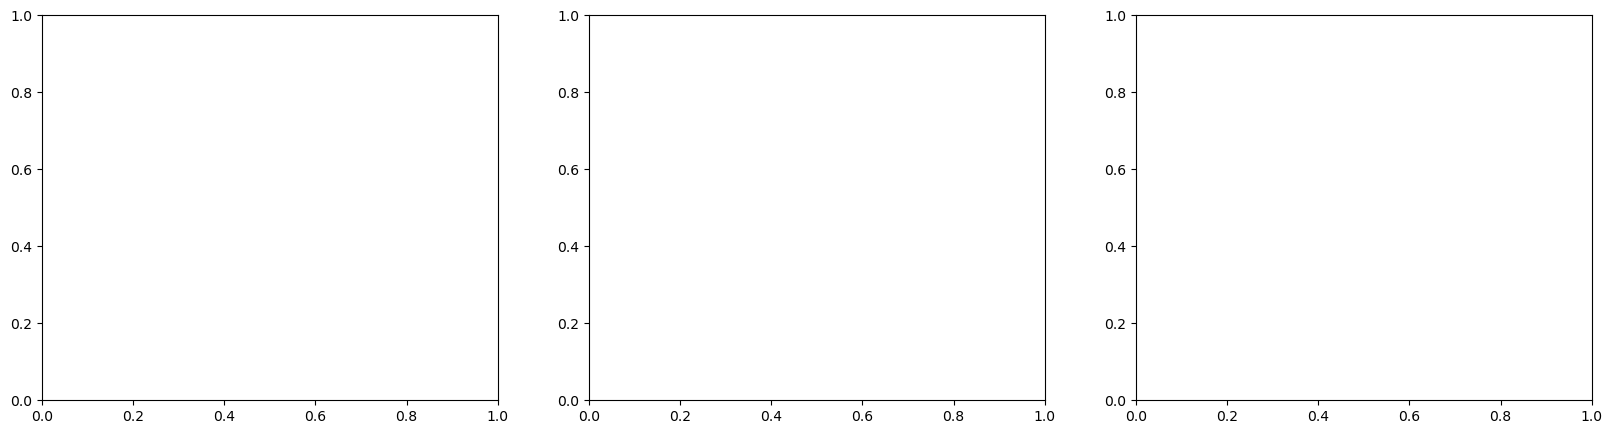

In [255]:
%matplotlib inline
import matplotlib.pyplot as plt 

dataset = 'GunPoint'

def visualize_experiment_1(dataset,model, ts, train):

    for model in ['fcn_mt_ae','fcn_mt_conv']: #['fcn_mt_ae','fcn_mt_conv', 'fcn_mt_linear']: 
        model_type = model.split('_')[0] 
        ylen = 1 
        idx = 0 if  train else 2
        data = read_dataset(data_p, archive, dataset, 'original', ylen)[dataset]
        #assertion,each ts has same length
        ylen = len(data[0][0])
        ig_data_stl  = read_dataset(data_p, archive, dataset, f'{model_type}_ig_norm', ylen)[dataset]

        ig_link  = f'./results/ucr/{dataset}/experiment_1/{model_type}/{model}_{itr}/{model_type}_ig_norm/last_model.hdf5'
        #cam_model =keras.models.load_model(cam_link ,compile=False)
        ig_model = keras.models.load_model(ig_link ,compile=False)

        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        fig = plt.gcf()
        
        #diff between train and test

        #Get x values
        x = ig_data_stl[idx]
        #Get attribution froms singeltask values
        stl_att = ig_data_stl[idx+1]
        #Get predicted values
        pred = ig_model.predict(x)[1]
        #Get attribution values used for prediction
        stl_pred_att = calculate_ig_attributions(data_p, archive, f"{model}_0", dataset, f"{model_type}_ig_norm", task=1)
        #Get attributen used for specific time series
        pred_att = stl_pred_att[0 if t == 1 else 1]

        #First row raw attribution vector: 
        axes[0].plot(norm(stl_att[ts]), label="train", linewidth=3)
        axes[0].set_title('Train Attribution')
        axes[1].plot(norm(pred[ts]), label="predicted", color='orange')
        axes[1].set_title('Prediction')
        axes[2].plot(norm(stl_att[ts]), linewidth=3)
        axes[2].plot(norm(pred[ts]), )
        axes[2].set_title('Comparison of all Attributions')


        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
        fig = plt.gcf()

        #Second row visulaization
        print(x[ts].shape,stl_att[ts].shape)
        #transformed x-values,y-values,attributionvalues for visualization only!
        xv,yv,av =prepare_visualize_attribution(x[ts],norm(stl_att[ts]))
        axes[0].scatter(xv,yv,c=av, cmap='jet', vmin=0,vmax=100, s=1, label='train')
        axes[0].set_title('Train Attribution')
        xv,yv,av =prepare_visualize_attribution(x[ts],norm(pred[ts]))
        axes[1].scatter(xv,yv,c=av, cmap='jet', vmin=0,vmax=100,s=1, label='attributed')
        axes[1].set_title("Prediction")
        #axes[1][3].plot()

        #plt.legend()
        plt.show()
        plt.draw()

visualize_experiment_1('ECG200','resnet_mt_ae',10, train=False)

### Fidelity Testing

In [28]:
from utils.evaluation import calculate_accuaracy_change
from utils.explanations import calculate_ig_attributions
from utils.utils import read_dataset
import numpy as np
import pandas as pd
from tensorflow import keras

archive_name = 'ucr'


#classifier = 'fcn_1'
classifier = 'fcn_mt_nn_iter_0.5_0'
cl_type = "fcn"
root_dir = "G:/Meine Ablage/master thesis/code/xai-tsc/"
itr = 1
appendix = 'original'
dataset_name = 'ECG200'

results  = pd.DataFrame(columns=["dataset","fcn_lerf","fcn_morf","resnet_lerf", "resnet_morf"])

results = []
for dataset_name in ["GunPoint", "ECG200","Beef"]:
    lerf_morf = [dataset_name]
    for classifier in ["fcn_1","resnet_1"]: 
        cl_type = classifier.split("_")[0]
        att = calculate_ig_attributions(root_dir, archive_name, classifier, dataset_name, 'original', task=0, scale='norm', experiment=1)
        x_train,y_train,x_test,y_test = read_dataset(root_dir, archive_name, dataset_name, 'original', 1)[dataset_name]
        loaded_model = keras.models.load_model(f"./results/ucr/{dataset_name}/experiment_1/{cl_type}/{classifier}/original/best_model.hdf5", compile=False)
        raw_att = [a[2] for a in att[1]]
        #pred_raw_att = loaded_model.predict(x_test)[1]
        # pred_raw_att = [a.flatten() for a in pred_raw_att]
        #print(raw_att.shape)
        lerf_change, morf_change = calculate_accuaracy_change(loaded_model,x_test,y_test,raw_att, mtl=False)
        lerf_morf.append([lerf_change, morf_change])
    results.append(lerf_morf)


G:/Meine Ablage/master thesis/code/xai-tsc//results/ucr/GunPoint//experiment_1/fcn/fcn_1/original/best_model.hdf5
5/5 [==============================] - 0s 8ms/step
G:/Meine Ablage/master thesis/code/xai-tsc//results/ucr/GunPoint//experiment_1/resnet/resnet_1/original/best_model.hdf5
5/5 [==============================] - 0s 24ms/step
G:/Meine Ablage/master thesis/code/xai-tsc//results/ucr/ECG200//experiment_1/fcn/fcn_1/original/best_model.hdf5
4/4 [==============================] - 0s 5ms/step
G:/Meine Ablage/master thesis/code/xai-tsc//results/ucr/ECG200//experiment_1/resnet/resnet_1/original/best_model.hdf5
4/4 [==============================] - 0s 15ms/step
G:/Meine Ablage/master thesis/code/xai-tsc//results/ucr/Beef//experiment_1/fcn/fcn_1/original/best_model.hdf5
1/1 [==============================] - 0s 50ms/step
G:/Meine Ablage/master thesis/code/xai-tsc//results/ucr/Beef//experiment_1/resnet/resnet_1/original/best_model.hdf5
1/1 [==============================] - 0s 77ms/step


In [29]:
new_results = []
for r in results: 
    new_results.append([r[0],*r[1],*r[2]])

pd.DataFrame(new_results,columns=["dataset","fcn_lerf","fcn_morf","resnet_lerf", "resnet_morf"]).to_latex("./results_csv/Experiment1a/results_lerf_morf.tex")

C:\Users\boent\AppData\Local\Temp\ipykernel_3056\345039900.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  pd.DataFrame(new_results,columns=["dataset","fcn_lerf","fcn_morf","resnet_lerf", "resnet_morf"]).to_latex("./results_csv/Experiment1a/results_lerf_morf.tex")
